#DATASET 1

In [1019]:
# packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.metrics import plot_confusion_matrix
from scipy.stats import norm, boxcox
from collections import Counter
from scipy import stats
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras_preprocessing import sequence

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score


# warning library
import warnings
warnings.filterwarnings("ignore")

In [1020]:
# # import csv files to Google Colab
# from google.colab import files
# uploaded = files.upload()

In [1021]:
# Read csv file and rawdata in dataframe type
def read_file(path):
    rawdata = pd.read_csv(path, header=0, delimiter=',')
    return rawdata

In [1022]:
# Show the accuracy and other matrices of accuracy
def report(predictions, y_test):
    print('Accuracy: %s' % accuracy_score(y_test, predictions))
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, predictions))
    print('Classification Report:')
    print(classification_report(y_test, predictions))

In [1023]:
# functions used to construct the decision tree classifier
def gini(sequence, weights=None):
    if weights is None: # count 1 - sum of square of probabilities
        _, counts = np.unique(sequence, return_counts=True)
        p = (counts / len(sequence)) ** 2  
        return 1.0 - np.sum(p)
    else:
        tot = 0
        weights = weights / weights.sum()
        for c in np.unique(sequence):
            #change prob become weighted prob
            tot = np.sum(weights[sequence == c]) ** 2
        return 1 - tot


def entropy(sequence, weights=None):
    if weights is None:
        _, counts = np.unique(sequence, return_counts=True)
        p = counts / len(sequence)  # probability
        return -np.sum(p * np.log2(p))
    else:
        entropy = 0
        weights = weights / weights.sum()
        for c in np.unique(sequence):
            # the weighted probability
            tmp = np.sum(weights[sequence == c])
            entropy -= tmp * np.log2(tmp)
        return entropy

In [1024]:
# Node
class Node():
    def __init__(self, c_value, prediction):
        self.c_value = c_value
        self.prediction = prediction
        self.feature_idx = None
        self.threshold = None
        self.left = None
        self.right = None

In [1025]:
# Decision tree built from scratch using gini and entropy
class DecisionTree():
    def __init__(self, criterion='gini', max_depth=None, max_features=None):
        self.criterion = globals()[criterion]

        self.max_depth = max_depth if max_depth is not None else 2 ** 100
        self.max_features = max_features
        self.n_features = None

    def fit(self, x_data, y_data, sample_weight=None):
        self.n_features = x_data.shape[1]
        self.root = self.get_node(x_data, y_data, depth=0, sample_weight=sample_weight)

    def get_node(self, x, y, depth, sample_weight=None):
        weighted_counts = np.bincount(y, weights=sample_weight)
        prediction = np.argmax(weighted_counts)
            
        node = Node(c_value=self.criterion(y, sample_weight), prediction=prediction)
        if depth >= self.max_depth:
            return node

        node.feature_idx, node.threshold = self.best_split(x, y, sample_weight)
        if node.feature_idx is None:
            return node

        left_idx = x[:, node.feature_idx] < node.threshold
        x_left, y_left = x[left_idx], y[left_idx]
        x_right, y_right = x[~left_idx], y[~left_idx]

        # get child nodes recursively
        if sample_weight is not None:
            node.left = self.get_node(x_left, y_left, depth=depth + 1, sample_weight=sample_weight[left_idx])
            node.right = self.get_node(x_right, y_right, depth=depth + 1, sample_weight=sample_weight[~left_idx])
        else:
            node.left = self.get_node(x_left, y_left, depth=depth + 1)
            node.right = self.get_node(x_right, y_right, depth=depth + 1)

        return node

    def best_split(self, x, y, sample_weight):
        if len(y) <= 1:  
            return None, None

        parent_c = self.criterion(y, sample_weight)
        best_infog = -2 ** 64  
        best_idx, best_th = None, None

        if self.max_features is not None:
            available_features = np.random.choice(np.arange(self.n_features), size=self.max_features, replace=False)
        else:
            available_features = np.arange(self.n_features)

        for idx in available_features:
            sort_idx = np.argsort(x[:, idx])
            thresholds = x[sort_idx, idx]
            labels = y[sort_idx]

            for pos in range(1, len(y)):
                if thresholds[pos] == thresholds[pos - 1]:
                    continue

                if sample_weight is not None:
                    sorted_sample_weight = sample_weight[sort_idx]
                    left_c = self.criterion(
                        labels[:pos], sorted_sample_weight[:pos])
                    right_c = self.criterion(
                        labels[pos:], sorted_sample_weight[pos:])
                else:
                    left_c = self.criterion(labels[:pos])
                    right_c = self.criterion(labels[pos:])

                child_c = (pos * left_c + (len(y) - pos) * right_c) / len(y)
                infog = parent_c - child_c

                if infog > best_infog:
                    best_infog = infog
                    best_idx = idx
                    best_th = (thresholds[pos] + thresholds[pos - 1]) / 2

        return best_idx, best_th

    def predict(self, x_data):
        def util(self, x):
            cur_node = self.root
            while cur_node.left and cur_node.right:
                if x[cur_node.feature_idx] < cur_node.threshold:
                    cur_node = cur_node.left
                else:
                    cur_node = cur_node.right
                    
            return cur_node.prediction
        return np.stack([util(self, single_x) for single_x in x_data])


In [1026]:
def outliers(df, features):
    o_index = []
    for o in features:
        quart1 = np.percentile(df[o],25)
        quart3 = np.percentile(df[o],75)
        interquart = quart3 - quart1
        outlier = interquart * 1.5
        o_listindex = df[(df[o] < quart1 - outlier) | (df[o] > quart3 + outlier)].index
        o_index.extend(o_listindex)
        
    o_index = Counter(o_index)
    alloutliers = list(i for i, j in o_index.items() if j > 1.5) 
    
    return alloutliers

MAIN CODE

In [1027]:
# Read the csv files inserted
df = read_file('./X_train.csv')
df2 = read_file('./y_train.csv')
df3 = read_file('./X_test.csv')

In [1028]:
df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,7.0,0.23,0.40,1.6,0.063,NaN,67.0,0.99520,3.50,0.63,11.1
1,7.8,0.60,0.26,2.0,0.080,31.0,131.0,0.99622,NaN,0.52,9.9
2,9.7,0.69,0.32,2.5,0.088,22.0,91.0,0.99790,3.29,0.62,10.1
3,12.0,0.38,0.56,2.1,0.093,6.0,24.0,0.99925,3.14,0.71,10.9
4,6.4,0.64,0.21,1.8,0.081,14.0,31.0,0.99689,3.59,0.66,NaN


In [1029]:
df.shape

(1023, 11)

In [1030]:
df.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
count,958.000000,979.000000,963.000000,984.000000,971.000000,966.000000,978.000000,977.000000,965.000000,972.000000,965.000000
mean,8.373800,0.526118,0.274216,2.510010,0.087151,15.920807,45.801125,0.996776,3.308632,0.663580,10.445009
std,1.776455,0.176769,0.193308,1.270972,0.043777,10.158979,33.314198,0.001894,0.153336,0.176466,1.048401
min,4.600000,0.120000,0.000000,1.200000,0.012000,1.000000,6.000000,0.990200,2.740000,0.370000,8.400000
25%,7.100000,0.390000,0.100000,1.900000,0.071000,8.000000,22.000000,0.995650,3.210000,0.550000,9.550000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,37.000000,0.996800,3.310000,0.620000,10.200000
75%,9.300000,0.640000,0.430000,2.600000,0.091000,22.000000,60.000000,0.997870,3.400000,0.740000,11.100000
max,15.600000,1.330000,1.000000,15.400000,0.610000,66.000000,289.000000,1.003690,4.010000,2.000000,14.000000


In [1031]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023 entries, 0 to 1022
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         958 non-null    float64
 1   volatile_acidity      979 non-null    float64
 2   citric_acid           963 non-null    float64
 3   residual_sugar        984 non-null    float64
 4   chlorides             971 non-null    float64
 5   free_sulfur_dioxide   966 non-null    float64
 6   total_sulfur_dioxide  978 non-null    float64
 7   density               977 non-null    float64
 8   pH                    965 non-null    float64
 9   sulphates             972 non-null    float64
 10  alcohol               965 non-null    float64
dtypes: float64(11)
memory usage: 88.0 KB


In [1032]:
df1n2 = df.join(df2)

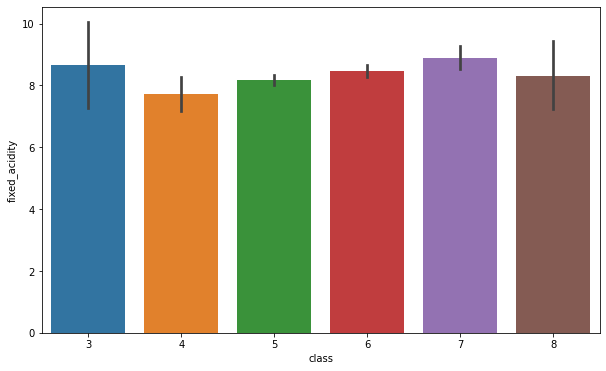

In [1033]:
# fixed_acidity doesn't affect much
fig = plt.figure(figsize = (10,6))
sns.barplot(x = 'class', y = 'fixed_acidity', data = df1n2)

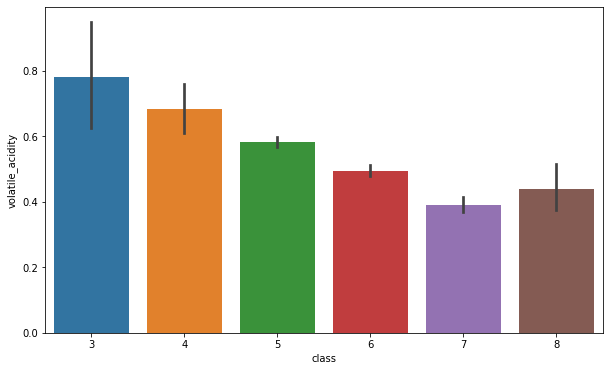

In [1034]:
# lower volatile acidity, higher quality
fig = plt.figure(figsize = (10,6))
sns.barplot(x = 'class', y = 'volatile_acidity', data = df1n2)

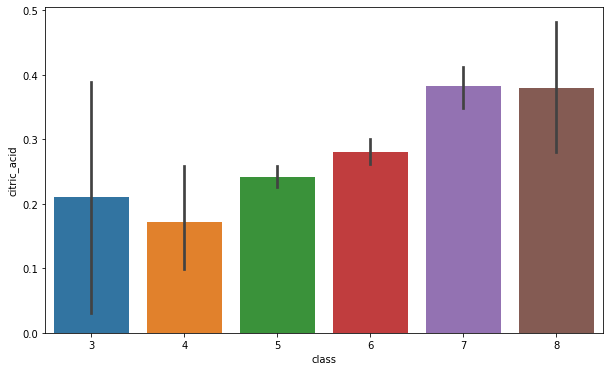

In [1035]:
# higher citric acid, higher quality
fig = plt.figure(figsize = (10,6))
sns.barplot(x = 'class', y = 'citric_acid', data = df1n2)

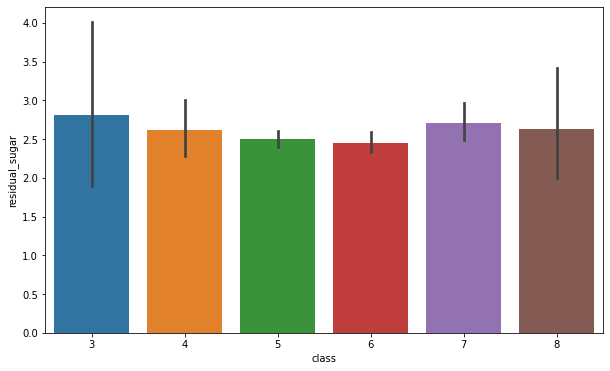

In [1036]:
# residual sugar doesn't affect much
fig = plt.figure(figsize = (10,6))
sns.barplot(x = 'class', y = 'residual_sugar', data = df1n2)

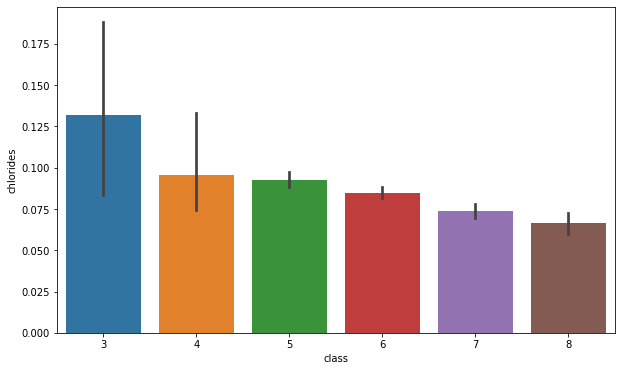

In [1037]:
# higher chlorides, lower quality
fig = plt.figure(figsize = (10,6))
sns.barplot(x = 'class', y = 'chlorides', data = df1n2)

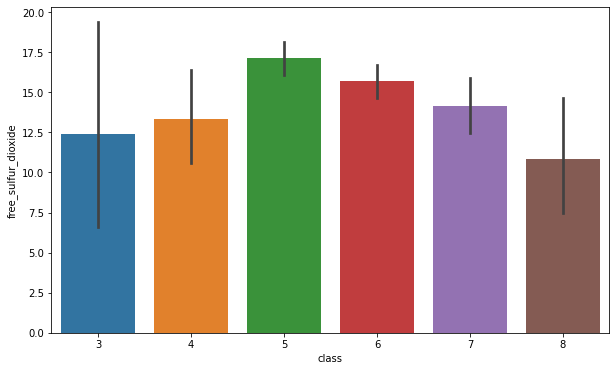

In [1038]:
# quality not so dependent on free sulfur dioxide
fig = plt.figure(figsize = (10,6))
sns.barplot(x = 'class', y = 'free_sulfur_dioxide', data = df1n2)

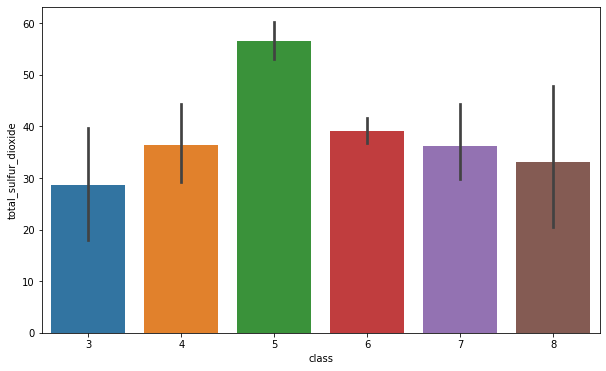

In [1039]:
# quality not so dependent on total sulfur dioxide
fig = plt.figure(figsize = (10,6))
sns.barplot(x = 'class', y = 'total_sulfur_dioxide', data = df1n2)

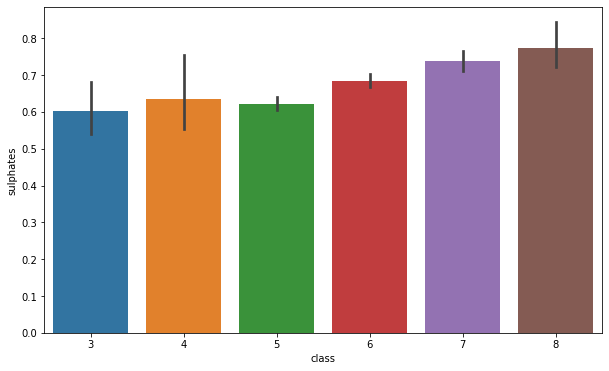

In [1040]:
# higher sulphates, higher quality
fig = plt.figure(figsize = (10,6))
sns.barplot(x = 'class', y = 'sulphates', data = df1n2)

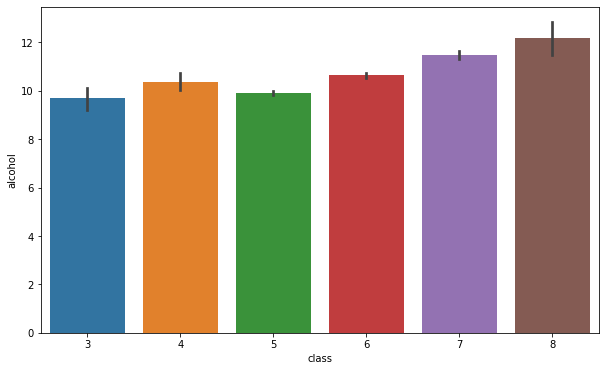

In [1041]:
# higher alcohol level, higher quality
fig = plt.figure(figsize = (10,6))
sns.barplot(x = 'class', y = 'alcohol', data = df1n2)

---> TRAIN

In [1042]:
# df1n2.columns[df1n2.isnull().any()]
df1n2.isnull().sum()

fixed_acidity           65
volatile_acidity        44
citric_acid             60
residual_sugar          39
chlorides               52
free_sulfur_dioxide     57
total_sulfur_dioxide    45
density                 46
pH                      58
sulphates               51
alcohol                 58
class                    0
dtype: int64

In [1043]:
df1n2 = df1n2.fillna(df1n2.mean())

In [1044]:
df1n2.isnull().sum()

fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
class                   0
dtype: int64

In [1045]:
len(df.loc[outliers(df,df.columns[:-1])]) # number of outliers

0

In [1046]:
df = df.drop(outliers(df,df.columns[:-1]),axis = 0).reset_index(drop = True)

In [1047]:
# binary classification good or bad
bins = (2, 6.5, 8)
classified = ['bad', 'good']
df1n2['class'] = pd.cut(df1n2['class'], bins = bins, labels = classified)

In [1048]:
df1n2['class'].value_counts()

bad     885
good    138
Name: class, dtype: int64

In [1049]:
classlabel = LabelEncoder() 
df1n2['class'] = classlabel.fit_transform(df1n2['class']) # numerized bad and good to 0 and 1

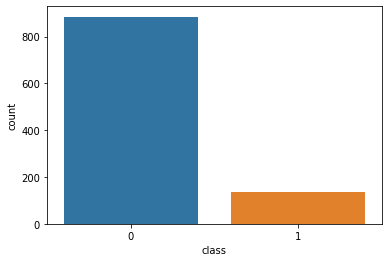

In [1050]:
sns.countplot(df1n2['class'])

In [1051]:
# declare feature and target values
X = df1n2.drop('class', axis = 1)
y = df2['class'].values

In [1052]:
# get optimized result
sc = StandardScaler()

In [1053]:
# Train and Test splitting of data 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [1054]:
X_train

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
137,6.3000,0.98,0.01,2.0,0.057,15.0,33.0,0.99488,3.60,0.46,11.2
377,7.2000,0.38,0.31,2.0,0.056,15.0,29.0,0.99472,3.23,0.76,11.3
388,6.6000,0.61,0.00,1.6,0.069,4.0,8.0,0.99396,3.33,0.37,10.4
824,10.9000,0.53,0.49,4.6,0.118,10.0,17.0,1.00020,3.07,0.56,11.7
767,7.0000,0.36,0.21,2.4,0.086,24.0,69.0,0.99556,3.40,0.53,10.1
...,...,...,...,...,...,...,...,...,...,...,...
106,8.3738,0.38,0.48,1.8,0.157,5.0,17.0,0.99760,3.30,1.05,9.4
270,7.7000,0.39,0.12,1.7,0.097,19.0,27.0,0.99596,3.16,0.49,9.4
860,8.9000,0.12,0.45,1.8,0.075,10.0,21.0,0.99552,3.41,0.76,11.9
435,7.1000,0.66,0.00,3.9,0.086,17.0,45.0,0.99760,3.46,0.54,9.5


In [1055]:
X_train = sc.fit_transform(X_train)
X_val = sc.fit_transform(X_val)

In [1056]:
# save preprocessed training data to a new csv file
final_traindf = pd.DataFrame(X) 
final_traindf.to_csv('X_train_final.csv') 

In [1057]:
# init decision tree classifier
clf = DecisionTree(max_depth=4)
clf.fit(X_train, y_train)

In [1058]:
# predict validation set
y_pred = clf.predict(X_val)
report(y_pred, y_val)

Accuracy: 0.6
Confusion Matrix:
[[ 0  4  3  0  0]
 [ 0 62 18  1  0]
 [ 0 30 45 11  0]
 [ 0  3  8 16  0]
 [ 0  1  1  2  0]]
Classification Report:
              precision    recall  f1-score   support

           4       0.00      0.00      0.00         7
           5       0.62      0.77      0.69        81
           6       0.60      0.52      0.56        86
           7       0.53      0.59      0.56        27
           8       0.00      0.00      0.00         4

    accuracy                           0.60       205
   macro avg       0.35      0.38      0.36       205
weighted avg       0.57      0.60      0.58       205



---> TEST

In [1059]:
# df3.columns[df3.isnull().any()]
df3.isnull().sum()

fixed_acidity           11
volatile_acidity        13
citric_acid             12
residual_sugar          12
chlorides                9
free_sulfur_dioxide     14
total_sulfur_dioxide    12
density                 12
pH                      10
sulphates                9
alcohol                 12
dtype: int64

In [1060]:
df3 = df3.fillna(df3.mean())

In [1061]:
len(df3.loc[outliers(df,df.columns[:-1])]) # number of outliers

0

In [1062]:
df3 = df3.drop(outliers(df3, df3.columns[:-1]),axis = 0).reset_index(drop = True)

In [1063]:
# declare feature and target values
X_test = df3.to_numpy()
X_test = sc.fit_transform(X_test)

In [1070]:
# save preprocessed testing data to a new csv file
final_traindf = pd.DataFrame(X_test) 
final_traindf.to_csv('X_test_final.csv') 

In [1065]:
# predict of testing dataset
ytest_pred = clf.predict(X_test)

In [1066]:
# write numpy array to csv
np.savetxt("y_test_final.csv", ytest_pred, delimiter=",")

In [1067]:
# # Reference of sklearn package DecisionTreeClassifier
# model = DecisionTreeClassifier()
# model.fit(X_train, y_train)
# predictions = model.predict(X_val)
# report(predictions, y_val)

In [1068]:
# finpredictions = model.predict(X_test_)